In [82]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append("../src")

from utils.io import load_pickle
from utils.feature import load_feature

pd.set_option('display.max_rows', 5000)


%matplotlib inline

plt.style.use("seaborn-v0_8")

誤差が大きいサンプルの特徴を知りたい

In [56]:
data = pd.read_csv("../data/preprocessed/train.csv")
oof_xgb = load_pickle("../data/model/xgb/seed=42/oof.pkl")


feature_names = [
    "word_count",
    "word_overlap_count",
    "text_length",
    "spell_miss_count",
    "sentence_count",
    "quotes_count",
    "quoted_sentence_count",
    "consecutive_dots_count",
]
features = load_feature("../data/feature", feature_names)
feat_df = pd.DataFrame(features, columns=feature_names)


data[["content_pred", "wording_pred"]] = oof_xgb
data = pd.concat([data, feat_df], axis=1)

In [57]:
data = data.assign(
    content_diff=lambda df: (df["content"] - df["content_pred"]).apply(np.square).apply(np.sqrt),
    wording_diff=lambda df: (df["wording"] - df["wording_pred"]).apply(np.square).apply(np.sqrt),
)

In [58]:
data.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text,content,wording,fold,content_pred,...,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count,content_diff,wording_diff
0,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,000e8c3c7ddb,The third wave was an experimentto see how peo...,0.205683,0.380538,3,0.099050,...,61,8,346,5,4,0,0,0,0.106633,0.300574
1,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",0020ae56ffbf,They would rub it up with soda to make the sme...,-0.548304,0.506755,2,-0.562738,...,52,8,244,2,3,0,0,0,0.014434,0.786914
2,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,004e978e639e,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1,2.749282,...,235,8,1370,32,13,2,2,0,0.379646,1.470820
3,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,005ab0199905,The highest class was Pharaohs these people we...,-0.210614,-0.471415,1,-1.092587,...,25,7,157,5,5,0,0,0,0.881973,0.485519
4,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,0070c9e7af47,The Third Wave developed rapidly because the ...,3.272894,3.219757,3,2.792049,...,203,8,1225,30,14,4,4,0,0.480845,0.758399


In [59]:
data.groupby("prompt_id")[["content_diff", "wording_diff"]].agg(["mean", "size"])

content_diff       wording_diff      
                  mean  size         mean  size
prompt_id                                      
39c16e        0.317639  2057     0.418856  2057
3b9047        0.354477  2009     0.498550  2009
814d6b        0.347295  1103     0.497863  1103
ebad26        0.341796  1996     0.423829  1996

`814d6b` は他と比べてサンプル数が少ない。 

全体的に `content` の誤差のほうが低い。

`wording` の中でも `814b6b` と `3b9047` の誤差が大きいのが気になる

一旦 content, wording の誤差を俯瞰してみる。

<Axes: xlabel='content_diff', ylabel='wording_diff'>

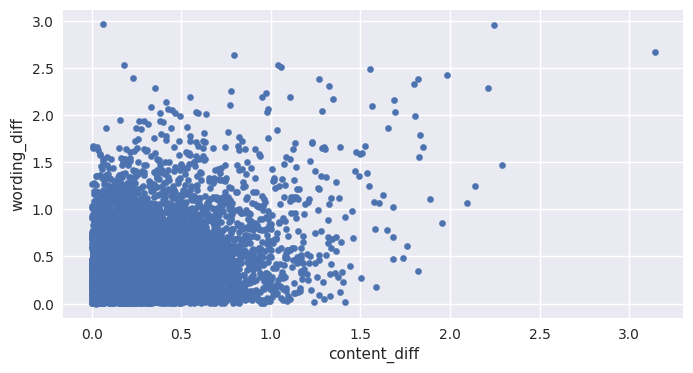

In [60]:
data.plot.scatter(x="content_diff", y="wording_diff", figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
dtype: object

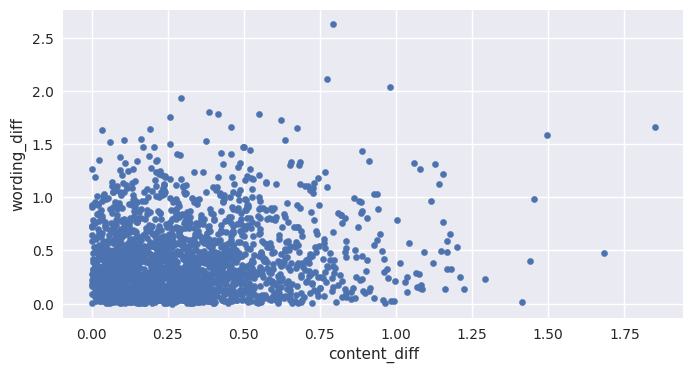

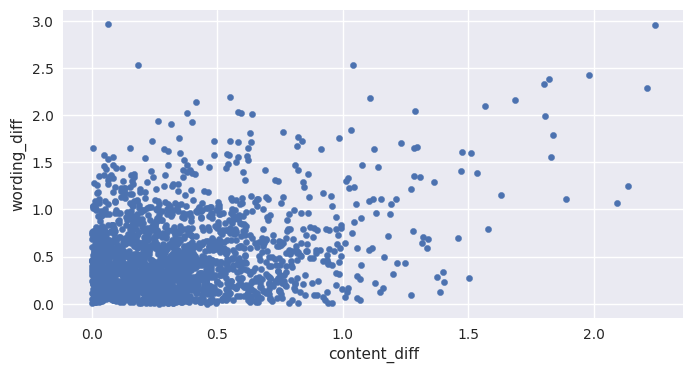

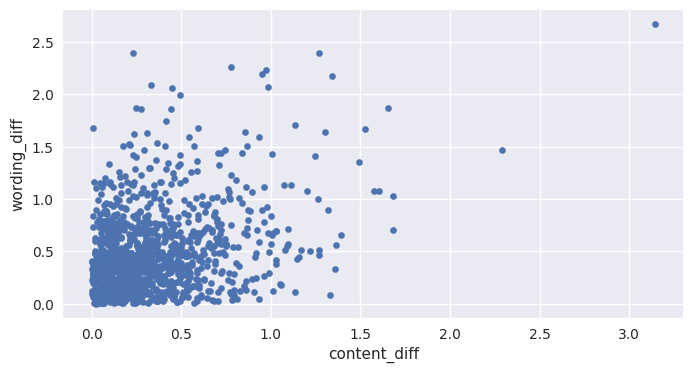

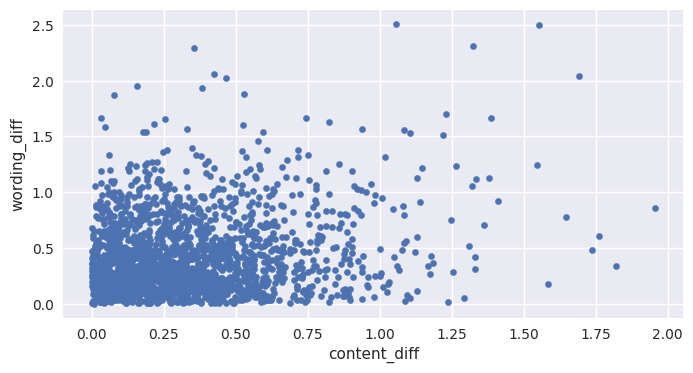

In [61]:
data.groupby("prompt_id").plot.scatter(x="content_diff", y="wording_diff", figsize=(8, 4))

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: content_diff, dtype: object

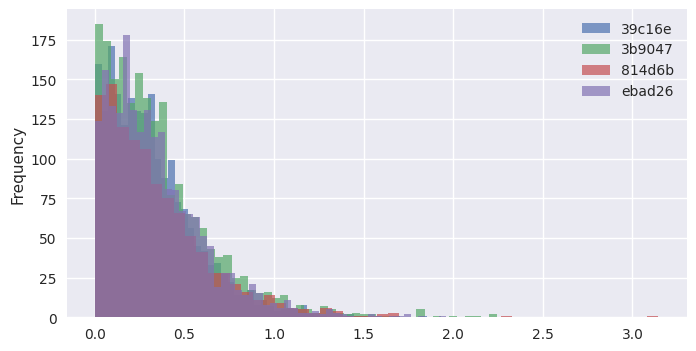

In [62]:
data.groupby("prompt_id")["content_diff"].plot.hist(bins=50, figsize=(8, 4), alpha=0.7, legend=True)

prompt_id
39c16e    Axes(0.125,0.11;0.775x0.77)
3b9047    Axes(0.125,0.11;0.775x0.77)
814d6b    Axes(0.125,0.11;0.775x0.77)
ebad26    Axes(0.125,0.11;0.775x0.77)
Name: wording_diff, dtype: object

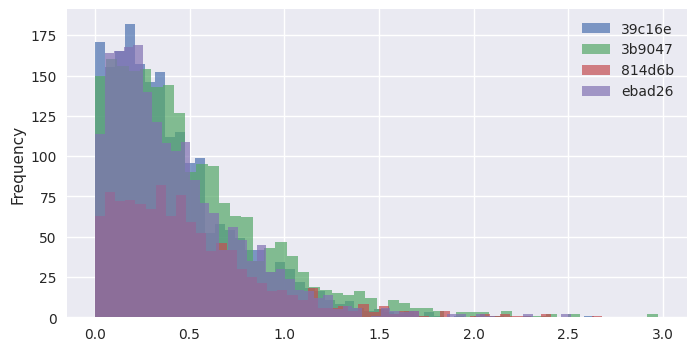

In [63]:
data.groupby("prompt_id")["wording_diff"].plot.hist(bins=50, figsize=(8, 4), alpha=0.7, legend=True)

## `3b9047` の誤差を詳細に見る

In [64]:
tmp = data.query("prompt_id == '3b9047'")

<Axes: xlabel='wording_diff'>

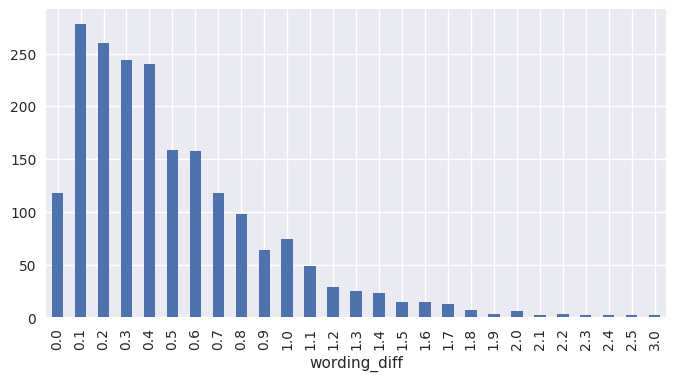

In [69]:
tmp["wording_diff"].round(1).value_counts().sort_index().plot.bar(figsize=(8, 4))

In [75]:
tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)
tmp.groupby("wording_diff_bin")[feature_names].mean()

,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count
wording_diff_bin,,,,,,,,
0.0,80.016949,7.949153,464.711864,11.745763,6.355932,0.364407,0.677966,0.008475
0.1,74.161871,7.931655,433.086331,10.928058,5.715827,0.345324,0.597122,0.043165
0.2,73.480769,7.961538,426.588462,10.515385,5.565385,0.296154,0.503846,0.019231
0.3,76.852459,7.967213,447.545082,11.336066,5.926230,0.274590,0.512295,0.040984
0.4,75.525000,7.954167,439.729167,11.458333,5.920833,0.320833,0.616667,0.083333
0.5,74.566038,7.943396,434.308176,11.018868,5.899371,0.314465,0.666667,0.044025
0.6,78.253165,7.987342,458.316456,11.493671,6.113924,0.322785,0.594937,0.025316
0.7,85.559322,7.940678,502.686441,12.923729,7.025424,0.347458,0.584746,0.050847
0.8,93.489796,7.979592,542.755102,14.306122,6.867347,0.418367,0.795918,0.010204


## `814d6b` の誤差を詳細に見る

<Axes: xlabel='wording_diff'>

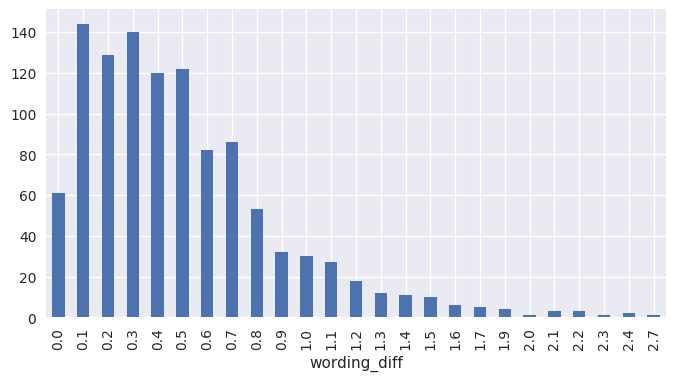

In [79]:
tmp = data.query("prompt_id == '814d6b'")

tmp["wording_diff"].round(1).value_counts().sort_index().plot.bar(figsize=(8, 4))

In [80]:
tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)
tmp.groupby("wording_diff_bin")[feature_names].mean()

/tmp/ipykernel_457366/860738255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, "wording_diff_bin"] = tmp["wording_diff"].round(1)


,word_count,word_overlap_count,text_length,spell_miss_count,sentence_count,quotes_count,quoted_sentence_count,consecutive_dots_count
wording_diff_bin,,,,,,,,
0.0,62.098361,7.950820,347.491803,5.786885,4.049180,0.098361,0.147541,0.000000
0.1,67.340278,7.909722,378.888889,6.736111,4.388889,0.131944,0.298611,0.055556
0.2,55.023256,7.914729,307.356589,5.612403,3.736434,0.085271,0.170543,0.023256
0.3,63.064286,7.857143,355.950000,6.335714,3.942857,0.121429,0.235714,0.014286
0.4,70.708333,7.950000,401.650000,7.158333,4.800000,0.100000,0.308333,0.050000
0.5,65.622951,7.909836,369.418033,6.737705,4.418033,0.147541,0.344262,0.024590
0.6,64.402439,7.914634,362.268293,6.231707,4.158537,0.121951,0.207317,0.000000
0.7,81.093023,7.918605,455.255814,8.000000,4.930233,0.209302,0.395349,0.023256
0.8,87.377358,7.962264,497.698113,9.132075,5.339623,0.245283,0.377358,0.018868


`word_count` が大きいほど誤差が大きいのが特徴的。

例外はある。前半に予測に寄与する単語が入ってるとかなのか？binごとのサンプルは少ないだろうから分散はそれなりにありそう。

他のprompt_idのも見てみる。

In [84]:
data.loc[:, "wording_diff_bin"] = data["wording_diff"].round(1)
data.groupby(["prompt_id", "wording_diff_bin"])[feature_names].mean()

word_count  word_overlap_count  text_length  \
prompt_id wording_diff_bin                                                
39c16e    0.0                57.705521            7.987730   323.368098   
          0.1                59.542763            7.983553   333.210526   
          0.2                52.740964            7.984940   293.246988   
          0.3                55.450355            7.978723   309.886525   
          0.4                63.188596            7.986842   353.482456   
          0.5                67.527473            7.989011   380.214286   
          0.6                64.112782            7.969925   358.954887   
          0.7                61.892157            8.000000   345.156863   
          0.8                83.440476            7.964286   472.904762   
          0.9                72.430769            7.984615   405.015385   
          1.0                78.793103            7.965517   446.465517   
          1.1                76.355556            8.000000   428.511111   
          1.2                54.320000            7.920000   302.320000   
          1.3                81.850000            8.000000   460.050000   
          1.4                58.000000            8.000000   329.555556   
          1.5                81.555556            8.000000   462.777778   
          1.6               113.250000            8.000000   606.750000   
          1.7               185.500000            8.000000  1065.250000   
          1.8               110.000000            8.000000   654.250000   
          1.9                87.000000            8.000000   479.000000   
          2.0               304.000000            8.000000  1759.000000   
          2.1               415.000000            8.000000  2393.000000   
          2.6               641.000000            8.000000  3711.000000   
3b9047    0.0                80.016949            7.949153   464.711864   
          0.1                74.161871            7.931655   433.086331   
          0.2                73.480769            7.961538   426.588462   
          0.3                76.852459            7.967213   447.545082   
          0.4                75.525000            7.954167   439.729167   
          0.5                74.566038            7.943396   434.308176   
          0.6                78.253165            7.987342   458.316456   
          0.7                85.559322            7.940678   502.686441   
          0.8                93.489796            7.979592   542.755102   
          0.9                93.796875            7.984375   542.625000   
          1.0                93.445946            7.972973   548.986486   
          1.1               113.102041            8.000000   673.714286   
          1.2               106.172414            8.000000   638.172414   
          1.3               112.280000            8.000000   651.600000   
          1.4               111.565217            8.000000   684.130435   
          1.5               157.133333            7.933333   931.533333   
          1.6               144.133333            8.000000   856.133333   
          1.7               136.230769            8.000000   831.846154   
          1.8               111.714286            8.000000   672.285714   
          1.9               202.333333            8.000000  1166.666667   
          2.0               204.333333            8.000000  1211.666667   
          2.1               182.500000            8.000000  1141.500000   
          2.2               162.666667            8.000000  1005.333333   
          2.3               138.000000            8.000000   826.500000   
          2.4               190.500000            8.000000  1201.000000   
          2.5               186.000000            8.000000  1125.000000   
          3.0               298.000000            8.000000  1857.500000   
814d6b    0.0                62.098361            7.950820   347.491803   
          0.1                67.340278            7.9

他のprompt_idも同様の傾向が見られる。

`wording` とある通り、実際には全文目を通してスコアをつけているから後半の部分が無視されている可能性が高い。


対策として、contentはprompt_text+summary text とし、wordingはsummary textのみとするのはどうだろうか。

`content` も見てみる。

In [85]:
data.loc[:, "content_diff_bin"] = data["content_diff"].round(1)
data.groupby(["prompt_id", "content_diff_bin"])[feature_names].mean()

word_count  word_overlap_count  text_length  \
prompt_id content_diff_bin                                                
39c16e    0.0                57.371287            7.980198   319.900990   
          0.1                61.941032            7.990172   347.422604   
          0.2                55.737752            7.988473   310.181556   
          0.3                55.974930            7.980501   312.055710   
          0.4                59.665272            7.987448   334.573222   
          0.5                65.289773            7.988636   367.613636   
          0.6                68.639344            7.959016   385.491803   
          0.7                72.195122            7.975610   406.975610   
          0.8               107.714286            7.928571   611.214286   
          0.9                94.937500            8.000000   538.031250   
          1.0               108.411765            8.000000   615.941176   
          1.1                99.285714            7.928571   563.500000   
          1.2                89.272727            8.000000   513.272727   
          1.3               193.000000            8.000000  1085.000000   
          1.4               142.000000            8.000000   842.000000   
          1.5               210.500000            8.000000  1111.000000   
          1.7                92.000000            8.000000   513.000000   
          1.9               200.000000            8.000000  1111.000000   
3b9047    0.0                81.971831            7.957746   476.061033   
          0.1                75.514451            7.968208   441.014451   
          0.2                72.388715            7.940439   420.144201   
          0.3                73.327160            7.962963   427.067901   
          0.4                87.310638            7.965957   511.080851   
          0.5                86.287425            7.964072   508.251497   
          0.6                98.229508            7.950820   571.540984   
          0.7               107.917647            7.952941   641.776471   
          0.8                88.578125            7.968750   526.328125   
          0.9                89.285714            7.971429   530.457143   
          1.0                99.322581            8.000000   586.580645   
          1.1               123.421053            8.000000   724.736842   
          1.2               135.272727            8.000000   800.818182   
          1.3               139.916667            8.000000   842.166667   
          1.4               119.600000            8.000000   696.400000   
          1.5               134.666667            8.000000   811.000000   
          1.6               111.333333            8.000000   696.000000   
          1.7               126.000000            8.000000   780.000000   
          1.8               155.400000            8.000000   952.600000   
          1.9               128.000000            8.000000   759.000000   
          2.0               163.000000            8.000000  1002.000000   
          2.1               227.500000            8.000000  1268.500000   
          2.2               259.000000            8.000000  1567.000000   
814d6b    0.0                63.155172            7.905172   354.500000   
          0.1                62.842593            7.921296   352.791667   
          0.2                68.081522            7.907609   384.836957   
          0.3                68.419162            7.910180   388.353293   
          0.4                70.882883            7.891892   401.540541   
          0.5                74.354167            7.958333   421.364583   
          0.6                84.350000            7.933333   474.783333   
          0.7                90.195652            7.978261   512.347826   
          0.8                96.357143            7.964286   552.928571   
          0.9                84.478261            8.000000   483.956522   
          1.0               114.150000            7.9

debertaが観測できていない単語や単語ごとの特徴量をもっと加える方向性を探ってみる。

あとはprompt questionに対しての異なる表現でのうまい言い回しをしていたりすると評価が高いかもしれない。

## Feature idea

- 単語の長さの最大、平均、中央
- debertaのmax_lenを1024などの512以上の値にする